## TMA4215 - Project #2 ## 
*01.11.2024*

*Group ID: 1216*

In this project we will work with image generation and processing. We begin by generating artificial fractal images through Newton iteration on complex functions. Then we focus on creating and manipulating shapes in the plane using Bézier curves and Hermite interpolation. Finally, we will use seamless cloning, which involves smoothly embedding one image within another for a coherent final result. 

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from typing import Callable, List, Tuple
import matplotlib.image
import scipy.sparse as sp
from scipy.sparse import diags, kron, csr_matrix
from PIL import Image
from scipy.sparse.linalg import cg
import matplotlib.image as img
from skimage.draw import ellipse
from skimage.morphology import binary_erosion
import sys
#np.set_printoptions(threshold=sys.maxsize)

In [57]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

#### Task 1: Generating artificial images

To start off we will generate artificial fractal images.

#### a)

We begin by defining a generic Newton iteration function.

In [58]:
def my_newton(f: Callable, Df: Callable, x0: float, maxiter: int=100, tol: float=1e-6) -> float:
    '''
    Perform Newton method

    Parameters:
    - f: function
    - Df: derivative of function
    - x0: initial guess
    - maxiter: maximum iterations (default 100) in case of no convergence
    - tol: tolerance for stopping criteria (default 1e-6)

    Returns:
    - x0: approximated root of f
    
    '''
    
    for _ in range(maxiter):
        x1 = x0 - f(x0) / Df(x0)
        if abs(x1 - x0) < tol:
            return x1
        x0 = x1

    return x0

#### b)

Now, we want to make a grid-based Newton function that uses `my_newton` as a helper function in order to run the Newton
iteration on a grid of possible starting values from the complex square

$$
\Omega = \left\{ x + iy \ \middle|\ -1 \leq x, y \leq 1 \right\},
$$

sampled equidistantly on n points (including the boundary).

In [59]:
def grid_newton(f: Callable, Df: Callable, n: int, maxiter: int=100) -> np.ndarray:
    '''
    Perform grid-based Newton method

    Uses my_newton as a helper function

    Parameters:
    - f: function
    - Df: derivative of function
    - n: the number of points along each axis of the grid. A grid of size `n x n` will be created
    - maxiter: maximum iterations (default 100)

    Returns:
    - A: matrix that stores the results of applying the Newton method to each point in the complex grid Z

    '''

    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    A = np.zeros(Z.shape, dtype=complex)
    
    for i in range(n):
        for j in range(n):
            A[i, j] = my_newton(f, Df, Z[i, j], maxiter=maxiter)

    return A

#### c)

We want to solve the equation $z^3 = 1, z \in \mathbb{C}$. 

**Analytical solution:**

We are tasked with finding the cube roots of unity, i.e., the solutions to the equation:
$$
z^3 = 1
$$

We can express $ 1 $ in polar form as:
$$
1 = e^{i \cdot 0} = e^{i \cdot 2k\pi}, \quad \text{for any integer } k
$$

The general form of a complex number $ z $ is:
$$
z = r e^{i \theta},
$$
where $ r $ is the modulus and $ \theta $ is the argument (angle).

To solve $ z^3 = 1 $, we substitute $ z = r e^{i\theta} $ and get:
$$
r^3 e^{i 3\theta} = e^{i \cdot 2k\pi}
$$

Thus
* $ r^3 = 1 \Rightarrow r = 1 $ (since $ r > 0 $),
* $ 3\theta = 2k\pi \Rightarrow \theta = \frac{2k\pi}{3} $

$$
\implies z_k = e^{i \frac{2k\pi}{3}}, \quad \text{for } k = 0, 1, 2
$$

This gives us the following roots:
$$
k = 0: ~ ~ ~ z_0 = e^{i \cdot 0} = 1,
$$
$$
k = 1:  ~ ~ ~ z_1 = e^{i \cdot \frac{2\pi}{3}} = -\frac{1}{2} + i\frac{\sqrt{3}}{2},
$$
$$
k = 2: ~ ~ ~ z_2 = e^{i \cdot \frac{4\pi}{3}} = -\frac{1}{2} - i\frac{\sqrt{3}}{2}
$$

We will now use Newton´s method to solve the equation. To apply the `grid_newton` method, we need the function and its derivative, as defined below.

In [60]:
def g(z):
    return z**3 - 1

def Dg(z):
    return 3 * z**2

We now define a function that creates a plot where each point $x \in \Omega$ is assigned a color based on the root (that we found analytically) to which the Newton iteration, starting from that point, converges.

In [111]:
def plot_sol(f: Callable, Df: Callable, roots: list, n: int=256, maxiter: int=100) -> None:
    '''
    Plots the Newton fractal for a given funciton

    Parameters:
    - f: function
    - Df: derivative of function
    - n: the resolution of the grid

    '''
    
    A = grid_newton(f, Df, n, maxiter=maxiter)
    
    # Create an empty array for the color plot
    img = np.zeros((n, n, 3))
    
    for i in range(n):
        for j in range(n):
            z = A[i, j]
            distances = [abs(z - root) for root in roots]
            closest_root = np.argmin(distances)
            # Using colors each corresponding to one of the roots
            img[i, j] = plt.get_cmap('hsv')(closest_root / len(roots))[:3] 
    
    plt.imshow(img, extent=(-1, 1, -1, 1))
    plt.title(f'Newton Fractal with {n}x{n} grid')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.show()

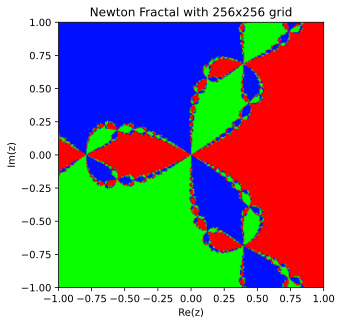

In [110]:
# Run the plotting function
roots = [1, np.exp(2j * np.pi / 3), np.exp(4j * np.pi / 3)]
plot_sol(g, Dg, roots, n=256)

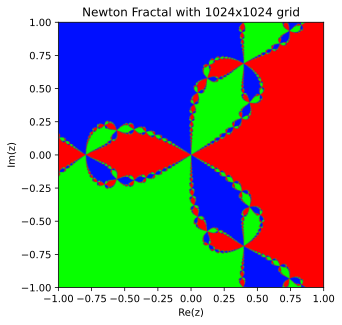

In [114]:
plot_sol(g, Dg, roots, n=1024)

Luckily we have a Macbook with the M3 chip, so we dare do to $n=1024$ aswell as $n=256$. We observe that the Newton fractal visually represents the basin of attraction for a function with three roots in the complex plane. Each color corresponds to points that converge to a particular root. In the boundary the convergence is highly sensitive to initial conditions, and we see that small changes in starting point can lead to convergence to different roots. For $n=1024$ the grid has a much finer resolution, resulting in smoother and more defined boundaries.

#### d)

We are now going to consider the equation $h(z) = z^{5} - 1$. Again, defining the function and its derivative.

In [112]:
def h(z):
    return z**5 - 1

def Dh(z):
    return 5*z**4

Now we get the roots and we plot the solution.

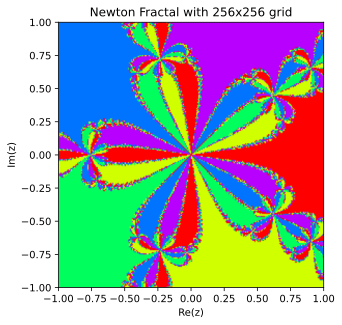

In [113]:
roots1 = [1, np.exp(2j * np.pi / 5), np.exp(4j * np.pi / 5), np.exp(6j * np.pi / 5), np.exp(8j * np.pi / 5)]
plot_sol(h, Dh, roots1, n=256)

We now have 5 roots which corresponds to 5 different colors in the basin of attraction.

We will now define the function `plot_angle` which plots the angle between the trivial solution $z_{0} = 1$ and the result from Newtons's method after $k$ steps for every starting point $x_{0} \in \Omega$.

In [115]:
def plot_angle(f: Callable, Df: Callable, n: int=256, maxiter: int=100) -> None:
    '''
    Plot the angle between the Newton iteration result at each grid point and the trivial solution

    Parameters:
    - f: function
    - Df: derivative of function
    - n: the number of points along each axis of the grid. A grid of size `n x n` will be created (default is 256)
    - maxiter: the maximum number of iterations for the Newton method (default is 100)

    '''

    z0 = 1
    A = grid_newton(f, Df, n, maxiter=maxiter)
    
    # Compute the angle between each grid point and the trivial solution
    angles = np.angle(A / z0)
    
    # Normalize the angles to the range [0, 1]
    norm_angles = (angles + np.pi) / (2 * np.pi)  # range [0, 1] since angles are in [-π, π]
    
    # Apply the colormap to the normalized angles
    cmap = plt.get_cmap('hsv')
    img_colors = cmap(norm_angles)
    
    # Plot the colored image
    plt.imshow(img_colors, extent=(-1, 1, -1, 1))
    plt.title(f'Newton Fractal with {n}x{n} grid after {maxiter} iterations')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.show()

We overwrite *maxiter* by $k=5,15$, to get the results from Newton´s method after $k$ steps.

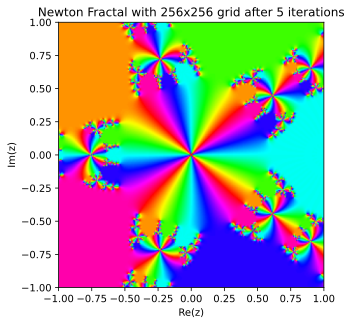

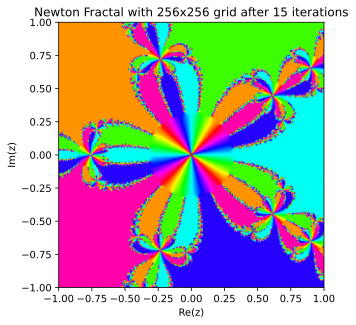

In [116]:
# Plotting for k = 5 iterations
plot_angle(h, Dh, n=256, maxiter=5)

# Plotting for k = 15 iterations
plot_angle(h, Dh, n=256, maxiter=15)


Here we define the function `animate` that creates a neat animation for visualizing the different plots inline in the Jupyter-notebook for $k=0,1,...,K$ steps.

In [119]:
def animate(k: int) -> List[matplotlib.image.AxesImage]:
    '''
    Update the plot for the given iteration step in the Newton method animation
    
    '''

    A = grid_newton(h, Dh, n, maxiter=k)
    angles = np.angle(A / z0)
    
    # Normalize the angles to the range [0, 1]
    norm_angles = (angles + np.pi) / (2 * np.pi)
    
    # Apply colormap
    img_colors = cmap(norm_angles)
    img.set_array(img_colors)
    ax.set_title(f'Newton Fractal - Iteration {k}')
    return [img]


In [120]:
# Setup for animation
n = 256 # Grid resolution
K = 20 # Maximum number of frames/iterations
z0 = 1 # Reference solution to calculate the angle
cmap = plt.get_cmap('hsv') # Choose the colormap

# Initialize the figure
fig, ax = plt.subplots()
A_initial = grid_newton(g, Dg, n, maxiter=0)
angles_initial = np.angle(A_initial / z0)
norm_angles_initial = (angles_initial + np.pi) / (2 * np.pi)
img_colors_initial = cmap(norm_angles_initial)
img = ax.imshow(img_colors_initial, extent=(-1, 1, -1, 1))
ax.set_title('Newton Fractal - Iteration 0')
ax.set_xlabel('Re(z)')
ax.set_ylabel('Im(z)')

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=range(K + 1), blit=True)
plt.close() # ensuring no extra plot under the animation

# Display as an HTML5 video inline in the notebook
HTML(anim.to_jshtml())

In the animated illustration we see the evolution of the Newton fractal over multiple iterations. The Newton fractal structure emerges and becomes sharper as the Newton method progresses towards convergence. The angle based coloring highlights the convergence direction relative to the reference solutions, making the regions of attraction and their boundaries visually distinct.

#### Task 2: Bézier curves and shapes

Now, we will consider shapes in the plane using Bézier curves and Hermite interpolation.

The Bézier curve $\bold{b} : [0,1] \to \mathbb{R}^d$ is defined as
\begin{align*}
& \bold{b}_n(t; \bold{p}_0, ..., \bold{p}_n) = (1-t) \bold{b}_{n-1} (t; \bold{p}_0, ..., \bold{p}_{n-1}) + t\bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n) \\
& \bold{b}_0(t;\bold{p}) = \bold{p}
\end{align*}

where $\bold{p}_0, ..., \bold{p}_n \in \mathbb{R}^d, n\in \mathbb{N}$ denote $n+1$ ordered points.

#### a)
Given a Bézier curve $\bold{c}(t) = \bold{b}_n(t; \bold{p}_0, ..., \bold{p}_n)$ we will prove that the following properties hold. 

**1) $\bold{c} (0) = \bold{p}_0$ and $\bold{c} (1) = \bold{p}_n$**

\begin{align*}
\bold{c}(0) & = \bold{b}_n \left(0; \bold{p}_0, ..., \bold{p}_n\right) \\
& = \left(1-0\right) \bold{b}_{n-1} \left(0; \bold{p}_0, ..., \bold{p}_{n-1}\right) + 0\bold{b}_{n-1} \left(0; \bold{p}_1, ..., \bold{p}_n\right) \\
& = \bold{b}_{n-1} \left(0; \bold{p}_0, ..., \bold{p}_{n-1}\right) \\
& = ... \\
& = \bold{b}_0 \left(0; \bold{p}_0\right) \\
& = \bold{p}_0

\end{align*}


\begin{align*}
\bold{c}(1) & = \bold{b}_n \left(1; \bold{p}_0, ..., \bold{p}_n\right) \\
& = \left(1-1\right) \bold{b}_{n-1} \left(1; \bold{p}_0, ..., \bold{p}_{n-1}\right) + 1\bold{b}_{n-1} \left(1; \bold{p}_1, ..., \bold{p}_n\right) \\
& = \bold{b}_{n-1} \left(1; \bold{p}_1, ..., \bold{p}_n\right) \\
& = ... \\
& = \bold{b}_0 \left(1; \bold{p}_n\right) \\
& = \bold{p}_n 

\end{align*}
$\square$


**2) $\bold{c}' (0) = n (\bold{p}_1 - \bold{p}_0)$ and $\bold{c}' (1) = n (\bold{p}_n -\bold{p}_{n-1})$ for $n \geq 1$**

First we compute the derivate of $\bold{c}$. Note that $n \geq 1$ is required because the first derivative involves at least two control points, and without these, there wouldn't be sufficient information to calculate curvature.

\begin{align*}
\bold{c}'(t) & = \frac{d}{dt} ((1-t) \bold{b}_{n-1} (t; \bold{p}_0, ..., \bold{p}_{n-1}) + t\bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n)) \\
& = - \bold{b}_{n-1} (t; \bold{p}_0, ..., \bold{p}_{n-1}) + (1-t) \frac{d}{dt} (\bold{b}_{n-1} (t; \bold{p}_0, ..., \bold{p}_{n-1})) + \bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n) + t \frac{d}{dt} (\bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n))
\end{align*}

Now we evaluate the derivative at $t=0$ and $t=1$

\begin{align*}
\bold{c}'(0) & = - \bold{b}_{n-1} (0; \bold{p}_0, ..., \bold{p}_{n-1}) + (1-0) \frac{d}{dt} (\bold{b}_{n-1} (0; \bold{p}_0, ..., \bold{p}_{n-1})) + \bold{b}_{n-1} (0; \bold{p}_1, ..., \bold{p}_n) + 0 \frac{d}{dt} (\bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n)) \\
& = - \bold{b}_{n-1} (0; \bold{p}_0, ..., \bold{p}_{n-1}) + \bold{b}_{n-1} (0; \bold{p}_1, ..., \bold{p}_n) 
\end{align*}

From 1) we know that $\bold{b}_{n-1} (0; \bold{p}_0, ..., \bold{p}_{n-1}) = \bold{p_0}$. We have to look at $\bold{b}_{n-1} (0; \bold{p}_1, ..., \bold{p}_n)$.

\begin{align*}
\bold{b}_{n-1} (0; \bold{p}_1, ..., \bold{p}_n) & = (1-0) \bold{b}_{n-2} (0; \bold{p}_1, ..., \bold{p}_{n-1}) + 0 \bold{b}_{n-2} (0; \bold{p}_2, ..., \bold{p}_n) \\
& = \bold{b}_{n-2} (0; \bold{p}_1, ..., \bold{p}_{n-1}) \\
& = ... \\
& = \bold{b}_0 (0; \bold{p}_1) \\
& = \bold{p}_1
\end{align*}

Moreover, the derivative of a Bézier curve is scaled by the degree of the Bézier curve we are differentiating. This comes from the fact that $\bold{p}_{i}$ are polynomials (specifically the Bernstein polynomials), and it is known that differentiating a polynomial of degree $n$ always indroduces a factor of $n$.
Thus, 
\begin{align*}
\bold{c}'(0)  = n(\bold{p}_1 - \bold{p}_0)
\end{align*}

Furthermore, 

\begin{align*}
\bold{c}'(1) & = - \bold{b}_{n-1} (1; \bold{p}_0, ..., \bold{p}_{n-1}) + (1-1) \frac{d}{dt} (\bold{b}_{n-1} (1; \bold{p}_0, ..., \bold{p}_{n-1})) + \bold{b}_{n-1} (1; \bold{p}_1, ..., \bold{p}_n) + 1 \frac{d}{dt} (\bold{b}_{n-1} (t; \bold{p}_1, ..., \bold{p}_n)) \\
& = - \bold{b}_{n-1} (1; \bold{p}_0, ..., \bold{p}_{n-1}) + \bold{b}_{n-1} (1; \bold{p}_1, ..., \bold{p}_n) 
\end{align*}

From 1) we know that $\bold{b}_{n-1} (1; \bold{p}_1, ..., \bold{p}_n) = \bold{p}_n$. We have to look at $\bold{b}_{n-1} (1; \bold{p}_0, ..., \bold{p}_{n-1})$.

\begin{align*}
\bold{b}_{n-1} (1; \bold{p}_0, ..., \bold{p}_{n-1}) & = (1-1) \bold{b}_{n-2} (1; \bold{p}_0, ..., \bold{p}_{n-2}) + 1 \bold{b}_{n-2} (1; \bold{p}_1, ..., \bold{p}_{n-1}) \\
& = \bold{b}_{n-2} (1; \bold{p}_1, ..., \bold{p}_{n-1}) \\
& = ... \\
& = \bold{b}_0 (1; \bold{p}_{n-1}) \\
& = \bold{p}_{n-1}
\end{align*}

Thus 
\begin{align*}
\bold{c}'(1)  = n(\bold{p}_n - \bold{p}_{n-1})
\end{align*}

$\square$

**3) $\bold{c}'' (0) = n (n-1) (\bold{p}_0 - 2\bold{p}_1 + \bold{p}_2)$ and $\bold{c}'' (1) = n (n-1) (\bold{p}_n - 2\bold{p}_{n-1} + \bold{p}_{n-2})$ for $n \geq 2$**

To compute the second derivative $c''(t)$, we differentiate the Bézier curve recursively. Note that $n \geq 2$ is required because the second derivative involves at least three control points.

We start with the recursive definition of $c'(t)$:
$$
c'(t) = -b_{n-1}(t; \bold{p}_0, \dots, \bold{p}_{n-1}) + (1 - t) \frac{d}{dt} b_{n-1}(t; \bold{p}_0, \dots, \bold{p}_{n-1}) + b_{n-1}(t; \bold{p}_1, \dots, \bold{p}_n) + t \frac{d}{dt} b_{n-1}(t; \bold{p}_1, \dots, \bold{p}_n)
$$

Now, we differentiate this expression again to obtain $c''(t)$:
$$
c''(t) = \frac{d}{dt} \left( -b_{n-1}(t; \bold{p}_0, \dots, \bold{p}_{n-1}) + b_{n-1}(t; \bold{p}_1, \dots, \bold{p}_n) \right)
$$
Applying the product rule:
$$
c''(t) = \frac{d}{dt} \left( -b_{n-1}(t; \bold{p}_0, \dots, \bold{p}_{n-1}) \right) + \frac{d}{dt} \left( b_{n-1}(t; \bold{p}_1, \dots, \bold{p}_n) \right)
$$
Simplifying further by differentiating each term:
$$
c''(t) = b_{n-2}(t; \bold{p}_0, \dots, \bold{p}_{n-2}) - 2b_{n-2}(t; \bold{p}_1, \dots, \bold{p}_{n-1}) + b_{n-2}(t; \bold{p}_2, \dots, \bold{p}_n)
$$

Now, let's evaluate $c''(t)$ at $t = 0$ and $t = 1$:

- At $t = 0$:
$$
c''(0) = n(n - 1)\left(\bold{p}_0 - 2\bold{p}_1 + \bold{p}_2\right)
$$
This result comes from the fact that the second derivative involves the difference of the control points scaled by the binomial coefficients. The factor $n(n - 1)$ arises due to the second differentiation of the polynomial.

- At $t = 1$:
$$
c''(1) = n(n - 1)\left(\bold{p}_n - 2\bold{p}_{n-1} + \bold{p}_{n-2}\right)
$$
Similarly, this result is derived by evaluating the second derivative at $t = 1$, with control points shifting to the last points in the list.

Thus, the second derivatives at $t = 0$ and $t = 1$ are:
$$
c''(0) = n(n - 1)(\bold{p}_0 - 2\bold{p}_1 + \bold{p}_2)
$$
$$
c''(1) = n(n - 1)(\bold{p}_n - 2\bold{p}_{n-1} + \bold{p}_{n-2})
$$

which holds for $n \geq 2$.


$\square$

#### b)
We can use the definition of the Bézier curve to define the de Casteljau algorithm to evaluate $\bold{b}_{n}(t_{0}; \bold{p}_{0}, ..., \bold{p}_{n})$ at $t_{0} \in [0,1]$.

In [122]:
def de_Casteljau(P: np.ndarray, t: float) -> Tuple[np.ndarray, List[np.ndarray]]:
    '''
    Implements the de Casteljau algorithm to compute a Bézier curve
    
    Parameters:
    - P: array of n + 1 points control points, that contains the control points
    - t: the parameter t in [0, 1]

    Returns:
    - P[0]: vector with final point of the Bézier curve at parameter t
    - Pvecs: list of intermediate points at each level of the de Casteljau algorithm
    
    '''

    n = len(P) - 1  # Degree of the Bézier curve
    Pvecs = [P]  # To store points at each level
    
    # Convert P to a numpy array for easier manipulation
    P = np.array(P)
    
    # Iteratively apply de Casteljau algorithm
    for k in range(1, n+1):
        new_points = (1 - t) * P[:-1] + t * P[1:]  # Compute intermediate points
        Pvecs.append(new_points)  # Store them
        P = new_points  # Update the control points for the next iteration
    
    return P[0], Pvecs

We will now plot the corresponding Bézier curve for the points 


$\bold{p}_{0} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}$, $\bold{p}_{1} = \begin{pmatrix} 2 \\ 3 \end{pmatrix}$, $\bold{p}_{2} = \begin{pmatrix} 4 \\ 0 \end{pmatrix}$, $\bold{p}_{3} = \begin{pmatrix} 6 \\ -3 \end{pmatrix}$, $\bold{p}_{4} = \begin{pmatrix} 8 \\ 0 \end{pmatrix}$




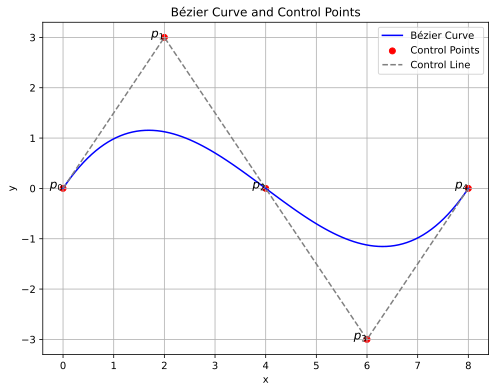

In [123]:
P = np.array([
    [0, 0], 
    [2, 3], 
    [4, 0], 
    [6, -3], 
    [8, 0]
])

# Generate Bézier curve points
t_values = np.linspace(0, 1, 100)
curve = np.array([de_Casteljau(P, t)[0] for t in t_values])

# Plotting
plt.figure(figsize = (8,6))
plt.plot(curve[:, 0], curve[:, 1], label="Bézier Curve", color='blue')

# Plotting control points and control line
P_array = np.array(P)
plt.scatter(P_array[:, 0], P_array[:, 1], color='red', label="Control Points")
plt.plot(P[:, 0], P[:, 1], '--', color='grey', label='Control Line')
for i, (x, y) in enumerate(P):
    plt.text(x, y, f'$p_{i}$', fontsize=12, ha='right')

plt.title("Bézier Curve and Control Points")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


From this we gain an intuitive look at the role of each control point in shaping the smooth, continuous curve.

#### c)

Using the points $\bold{p}_0, ..., \bold{p}_n \in \mathbb{R}^d$ and $\bold{q}_0, ..., \bold{q}_n \in \mathbb{R}^d$, we define the segments Bézier curves $\bold{c}(t) = \bold{b}(t; \bold{p}_0, ..., \bold{p}_n)$ and $\bold{d}(t) = \bold{b}(t; \bold{q}_0, ..., \bold{q}_n)$. Then the composite or piecewise Bézier curve $\bold{s} : [0,2] \to \mathbb{R}^d$ is defined by

\begin{align*} 
\bold{s}(t) =  
\begin{cases}
\bold{c}(t)  & \text{for } 0 \leq t < 1\\
\bold{d}(t-1)  & \text{for } 1 \leq t \leq 2
\end{cases}
\end{align*} 

**1)**

To ensure that $\bold{s} \in C^0([0,2])$, $\bold{s}(t)$ must be continuous over the interval $[0,2]$. Thus, for $t=1$ we require the following condition:
$$
\lim_{t \to 1^-} c(t) = \lim_{t \to 1^+} d(t - 1)
$$
which simplifies to
$$
\bold{c}(1) = \bold{d}(0)
$$

For continuity, the end point of the curve $\bold{c}(t)$, which is $\bold{c}(1)$, must coincide with the starting point of the curve $d(t)$, which is $d(0)$.

In terms of control points, since $\bold{c}(1) = \bold{b}(1; \bold{p}_0, ..., \bold{p}_n)$ and $\bold{d}(0) = \bold{b}(0; \bold{q}_0, ..., \bold{q}_n)$, we get from the results in $2a)$ that:

$$\bold{p}_n = \bold{q}_0$$


**2)**

For $\bold{s} \in C^1([0,2])$, we also need $\bold{s}'(t)$ to be continuous over the interval $[0,2]$. We now require that the first derivatives of $\bold{c}(t)$ and $\bold{d}(t - 1)$ match at $t = 1$. This can be written as:

$$
\lim_{t \to 1^-} \frac{d}{dt}\bold{c}(t) = \lim_{t \to 1^+} \frac{d}{dt}\bold{d}(t - 1)
$$

By applying the chain rule to the right-hand side:

$$
\frac{d}{dt}\bold{d}(t - 1) = \frac{d}{du}\bold{d}(u) \cdot \frac{d}{dt}(t - 1) = \frac{d}{du}\bold{d}(u)
$$

where $u = t - 1$. Thus, the condition for continuous differentiability simplifies to:

$$
\bold{c}'(1) = \bold{d}'(0)
$$

Therefore, for continuous differentiability, the tangent vector at the end of $\bold{c}(t)$ must equal the tangent vector at the beginning of $\bold{d}(t)$.

We saw in $2a)$ that the derivatives can be expressed as:

\begin{align*}
& \bold{c}'(1) = n(\bold{p}_n - \bold{p}_{n-1})\\
& \bold{d}'(0) = n(\bold{q}_1 - \bold{q}_{0})
\end{align*}

Thus, for $\bold{s} \in C^1([0,2])$ the following conditions must hold:
* $\bold{p}_n = \bold{q}_0$
* $\bold{p}_n - \bold{p}_{n-1} = \bold{q}_1 - \bold{q}_{0} \implies \bold{p}_{n-1} = 2 \bold{q}_{0} - \bold{q}_1$

For the case $n=3$, we have a cubic Bézier curve defined by four points $\bold{p}_0, \bold{p}_1, \bold{p}_2, \bold{p}_3$ for $\bold{c}(t)$ and $\bold{q}_0, \bold{q}_1, \bold{q}_2, \bold{q}_3$ for $\bold{d}(t)$. So the conditions for $\bold{s} \in C^1([0,2])$ reduce to:
* $\bold{p}_3 = \bold{q}_0$
* $\bold{p}_{2} = 2\bold{q}_0 - \bold{q}_{1}$

**3)**

We are given that $n = 3$, and the points $\bold{d}_0$, $\bold{d}_1$, and $\bold{d}_2$ are interpolated by the piecewise Bézier curve $\bold{s}(t)$. 

The curve must pass through the given points $\bold{d}_0$, $\bold{d}_1$, and $\bold{d}_2$:
$$
\bold{s}(0) = \bold{d}_0, \quad \bold{s}(1) = \bold{d}_1, \quad \bold{s}(2) = \bold{d}_2
$$

* For $\bold{s}(0) = \bold{d}_0 \implies \bold{c}(0) = \bold{p}_0 = \bold{d}_0$
* For $\bold{s}(1) = \bold{d}_1 \implies \bold{d}(0) = \bold{d}_1$, which with continuity requires $\bold{p}_3 = \bold{d}_1$ and $\bold{q}_0 = \bold{d}_1$
* For $\bold{s}(2) = \bold{d}_2 \implies \bold{d}(1) = \bold{d}_2$, which requires $ \bold{q}_3 = \bold{d}_2$

Given these conditions, we have left the following four free points $\bold{p}_1, \bold{p}_2, \bold{q}_1, \bold{q}_2$. This allows for 4 degrees of freedom to adjust the curve shape while satisfying the interpolation and differentiability conditions. 


**4)**

To have a $C^1$ function $\bold{s}(t)$ that is periodic, i.e., $\bold{s}(0) = \bold{s}(2)$, we need to add the following conditions:
* $\bold{c}(0) = \bold{d}(1)$
* $\bold{c}'(0) = \bold{d}'(1)$

From $2a)$ we know that:
* $\bold{c}(0) = \bold{p}_0$
* $\bold{d}(1) = \bold{q}_n = \bold{q}_3$
* $\bold{c}'(0) = n(\bold{p}_1 - \bold{p}_0)$
* $\bold{d}'(1) = n(\bold{q}_n - \bold{q}_{n-1})$

Therefore, the additional conditions for periodicity in $C^1$ is 
\begin{align*}
& \bold{p}_0 = \bold{q}_3 \\
& \bold{p}_1 = \bold{q}_3 - \bold{q}_2 + \bold{p}_0 = 2 \bold{q}_3 - \bold{q}_2
\end{align*}

#### d)
Given a number $m$ of segements and $4m$ points $\bold{p}_{0,i}, \bold{p}_{1,i}, \bold{p}_{2,i}, \bold{p}_{3,i}\in \mathbb{R}^d$ for $ i = 1, ..., m$, the *periodic composite Bézier curve* $\mathbb{B} : [0,m] \to \mathbb{R}^d$ is defined by

$$ \bold{B}(t) = b_3 (t-i+1; \bold{p}_{0,i}, \bold{p}_{1,i}, \bold{p}_{2,i}, \bold{p}_{3,i}) \text{ for } i-1 \leq t < i \text{ and each } i = 1, ..., m$$ 

which further is periodic, i.e $\bold{B}(0) = \bold{B}(m)$.

We will now implement a function `composite_bezier` that evaluates $\bold{B}(t), t \in [0,m]$, where $P= (\bold{p}_{j,i})_{j=0, i=1}^{3,m}$ denotes a matrix of control points.

In [124]:
def composite_bezier(P: np.ndarray, t: float) -> np.ndarray:
    '''
    Evaluate the periodic composite Bézier curve
    
    Parameters:
    - P: matrix of control points
    - t: position along the entire somposite Bézier curve 

    Returns:
    - point: the cubic Bézier for P

    '''

    m = P.shape[1]  # Number of segments
    t_mod = t % m  # Ensures periodicity (wrap around at t = m)
    
    # Finds the segment index i based on t
    i = int(np.floor(t_mod))
    
    # Computes the local t value within the segment
    t_local = t_mod - i
    
    # Get the control points for the segment
    p0 = P[0, i]
    p1 = P[1, i]
    p2 = P[2, i]
    p3 = P[3, i]
    
    # Evaluate the cubic Bézier for this segment
    point = (1 - t_local)**3 * p0 + 3 * (1 - t_local)**2 * t_local * p1 + 3 * (1 - t_local) * t_local**2 * p2 + t_local**3 * p3
    
    return point


In [126]:
def plot_cubic_bezier(P: np.ndarray, num_points: int=100) -> None:
    '''
    Plots the cubic bézier curve for some control points using composite_bezier()

    Parameters:
    - P: matrix if control points
    - num_point: number of points to evaluate along the composite Bézier curve (default is 100)
    
    '''
    
    t_values = np.linspace(0, P.shape[1], num_points)
    x_values = []
    y_values = []

    for t in t_values:
        point = composite_bezier(P,t)
        x_values.append(point[0])
        y_values.append(point[1])
        
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values)

    for i in range(P.shape[1]):
        plt.scatter([P[0, i][0], P[1, i][0], P[2, i][0], P[3, i][0]], 
                    [P[0, i][1], P[1, i][1], P[2, i][1], P[3, i][1]], 
                    color='red')
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Cubic Bezier Curve')
    plt.grid()


We will now test our function with the 3-segment cubic composite B spline given by:

$
P = \begin{bmatrix}
\begin{pmatrix} -1 \\ 0 \end{pmatrix} & \begin{pmatrix} 0 \\ 1 \end{pmatrix} & \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\[8pt]
\begin{pmatrix} -1 \\ \frac{1}{3} \end{pmatrix} & \begin{pmatrix} \frac{1}{3} \\ 1 \end{pmatrix} & \begin{pmatrix} 1 \\ -\frac{1}{3} \end{pmatrix} \\[8pt]
\begin{pmatrix} -\frac{1}{3} \\ 1 \end{pmatrix} & \begin{pmatrix} 1 \\ \frac{1}{3} \end{pmatrix} & \begin{pmatrix} \frac{1}{3} \\ -1 \end{pmatrix} \\[8pt]
\begin{pmatrix} 0 \\ 1 \end{pmatrix} & \begin{pmatrix} 1 \\ 0 \end{pmatrix} & \begin{pmatrix} 0 \\ -1 \end{pmatrix}
\end{bmatrix}
$

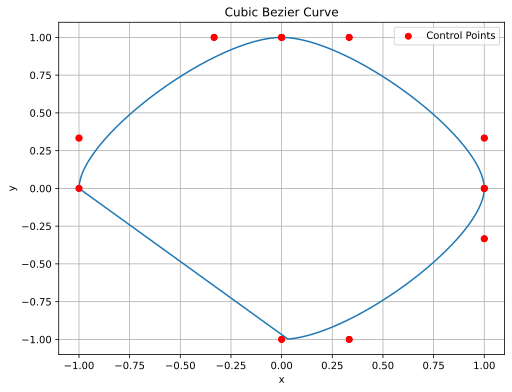

In [127]:
P = np.array([
    [[-1, 0], [0, 1], [1, 0]],
    [[-1, 1/3], [1/3, 1], [1, -1/3]],
    [[-1/3, 1], [1, 1/3], [1/3, -1]],
    [[0, 1], [1, 0], [0, -1]]
])

# Plotting
plot_cubic_bezier(P)
plt.scatter(P[:, :, 0].flatten(), P[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.legend()
plt.show()

We can see from the plot that we have a smooth and continuous periodic composite Bézier curve, with distinct control points that guide its structure. 

#### e)

We are now going to define `interpolate_periodic`, which we will use to find the periodic composite cubic Bézier curve $B(t)$ that maps from $[0,m]$ to $\mathbb{R}^{d}$, and fulfill the conditions:

- **$B(0) = B(m)$**
- **$B'(0) = B'(m)$**
- **$B(i) = \bold{a}_{i}$ for $i = 0,...,m-1$**
- **$B'(i) = \bold{v}_{i}$ for $i = 0,...,m-1$**

We denote the data points $\bold{a}_0, ..., \bold{a}_{m-1} \in \mathbb{R}^d$ in a matrix $A$, and velocities $\bold{v}_0, ..., \bold{v}_{m-1} \in \mathbb{R}^d$ in a matrix $V$.


In [129]:
def interpolate_periodic(A: np.ndarray, V: np.ndarray) -> np.ndarray:
    '''
    Interpolate a periodic cubic Bézier curve given points A and velocities V

    Parameters:
    - A: vector of the interpolation points 
    - V: vector of the velocities

    Returns:
    - P: matrix of the control points

    '''

    m = len(A)  # Number of points
    P = np.zeros((4, m, A.shape[1]))  # Matrix of control points, shape (4 control points, m segments, d dimensions)
    
    for i in range(m):
        # Compute the next point index, considering periodicity
        next_i = (i + 1) % m
        
        # Set control points for segment i
        P[0, i] = A[i]  # p0 = a_i
        P[1, i] = A[i] + (1/3) * V[i]  # p1 = a_i + 1/3 * v_i
        P[2, i] = A[next_i] - (1/3) * V[next_i]  # p2 = a_{i+1} - 1/3 * v_{i+1}
        P[3, i] = A[next_i]  # p3 = a_{i+1}
    
    return P

To test our function we use the arbitrary data points, $A$:

$
A = \begin{bmatrix}
-1 & 0 \\
0 & 1 \\
1 & 0 \\
-1 & -1
\end{bmatrix} \quad
$

and velocities, $V$:

$
V = \begin{bmatrix}
1 & 2 \\
0 & -2 \\
-1 & 0 \\
-1 & -2
\end{bmatrix}
$

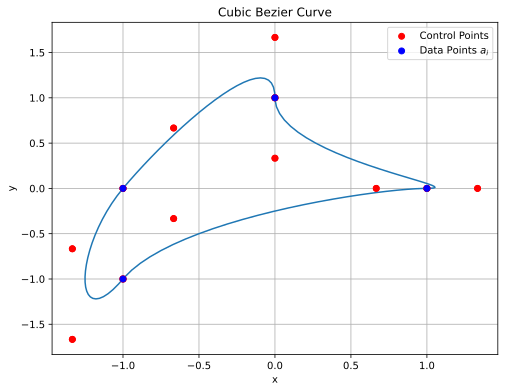

In [130]:
# Datapoints and velocities
A = np.array([[-1, 0], [0, 1], [1, 0], [-1,-1]])
V = np.array([[1, 2], [0, -2], [-1, 0], [-1,-2]])

# Compute the control points for the periodic Bezier curve
P_interpolated = interpolate_periodic(A, V)

# Plotting
plot_cubic_bezier(P_interpolated)
plt.scatter(P_interpolated[:, :, 0].flatten(), P_interpolated[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Data Points $a_i$', zorder=5)
plt.legend()
plt.show()

The cubic Bézier curve exhibits smooth, continous transition between the datapoints. The control points affect the curvature of the curve without enforcing any sharp bends.

#### f)
We are now going to draw the letter "T" using the `interpolate_periodic`. We know that the Bézier curve passes through the specified data points, while carefully choosing the velocities at each point to achieve the desired curvatures that accurately represent the shape of the letter. By controlling both the position and velocity, we can model the smooth transitions and sharp edges characteristic of the letter "T". 

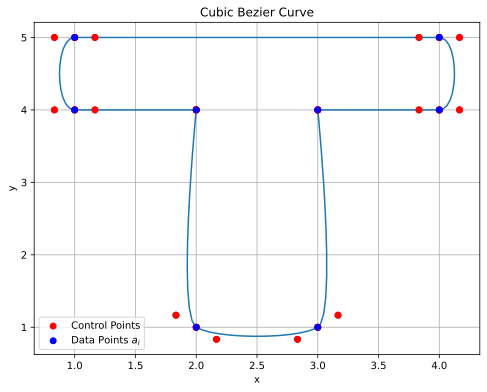

In [131]:
A = np.array([
    [2,1],
    [3,1],
    [3,4],
    [4,4],
    [4,5],
    [1,5],
    [1,4],
    [2,4] 
])

V = np.array([
    [0.5,-0.5],
    [0.5,0.5],
    [0,0],
    [0.5,0],
    [-0.5,0],
    [-0.5,0],
    [0.5,0],
    [0,0]
])

P = interpolate_periodic(A,V)

# Plotting
plot_cubic_bezier(P)
plt.scatter(P[:, :, 0].flatten(), P[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Data Points $a_i$', zorder=5)
plt.legend()
plt.show()

For constructing the letter we fixed the data points $a_i$ for all corners of "T". Then we decided the velocities based on which direction we wanted the curve to bend. When running our code, control points are generated from translating the data points by a scaled $V$.

#### g)
We are now going to play with our letter "T" and see what happens to the plot if we:

**1) scale all points by 2 and translate them by $\begin{pmatrix} 2 \\ 3 \end{pmatrix}$**

**2) rotate all points around the origin by $45^{o}$**

**3) do first 1) then 2)**

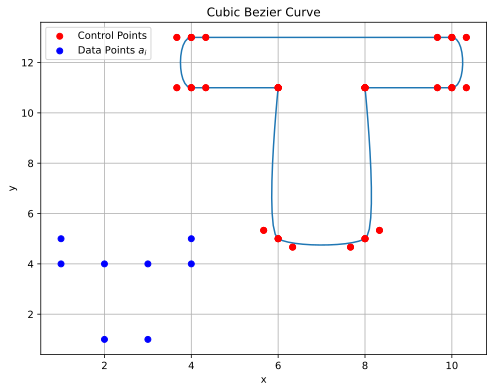

In [132]:
# 1) scale points by 2, then translate by (2 3)

P_transformed = P * 2 + np.array([2, 3])

# Plotting
plot_cubic_bezier(P_transformed)
plt.scatter(P_transformed[:, :, 0].flatten(), P_transformed[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Data Points $a_i$', zorder=5)
plt.legend()
plt.show()

We can observe our "T" is doubled in size and has been moved up and to the right, as a result of being translated by the vector $\begin{pmatrix} 2 \\ 3 \end{pmatrix}$.

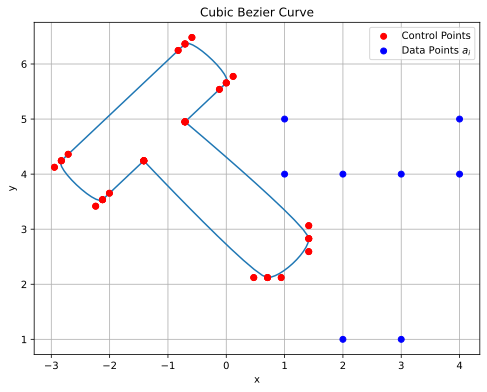

In [133]:
# 2) rotate the points around the origin by 45 degree

# Define the rotation matrix for a 45-degree rotation
theta = np.radians(45)  # Convert 45 degrees to radians
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

P_rotated = P @ rotation_matrix.T

# Plotting
plot_cubic_bezier(P_rotated)
plt.scatter(P_rotated[:, :, 0].flatten(), P_rotated[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Data Points $a_i$', zorder=5)
plt.legend()
plt.show()

Here our "T" has been rotated $45^{o}$ around the origin anti-clockwise. 

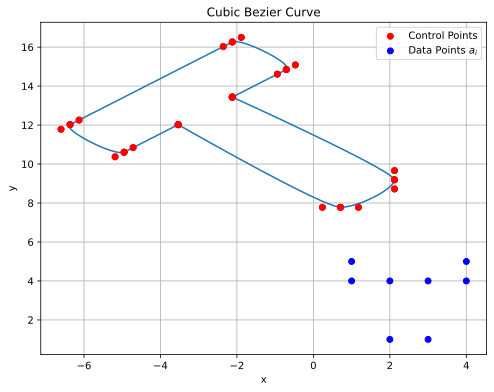

In [134]:
# First 1) then 2)

P3 = P_transformed @ rotation_matrix.T

# Plotting
plot_cubic_bezier(P3)
plt.scatter(P3[:, :, 0].flatten(), P3[:, :, 1].flatten(), color='red', label='Control Points', zorder=5)
plt.scatter(A[:, 0], A[:, 1], color='blue', label='Data Points $a_i$', zorder=5)
plt.legend()
plt.show()

We observe that by doing step 1) and 2) subsequently, we obtain a figure that has been doubled in size and translated, in addition to being rotated $45^{o}$ around the origin anti-clockwise.

#### Task 3: Seamless cloning

Now we want to smoothly embed one image into another, using seamless cloning.

Color images consist of red, green, and blue channels at each pixel, which we represent as an $ m+2 $-by-$ n+2 $ image. This image is modeled as a function $ G $ from a domain $ \Omega $ to $ \mathbb{R}^3 $, where $ \Omega = [0, \dots, m+1] \times [0, \dots, n+1] \subset \mathbb{Z}^2 $. In the following, we work with each of the three color channels separately, meaning that we treat $ g : \Omega \to \mathbb{R} $ for each channel. Rather than interpreting the image simply as a function on a grid, we can think of the matrix $ g(\Omega) $ as belonging to $ \mathbb{R}^{(m+2) \times (n+2)} $. We split this image into two parts: the "inner" part $ g(\overset{\circ}{\Omega}) $, which belongs to $ \mathbb{R}^{m \times n} $, and the boundary $ g(\partial \Omega) $, which contains $ 2m + 2n + 4 $ pixels. This gives us $ \Omega = \overset{\circ}{\Omega} \cup \partial \Omega $.

Given an image $ F: \Psi \to \mathbb{R}^3 $, where $ \Psi \subset \mathbb{Z}^2 $, we aim to incorporate each $ g $ into the respective color channel $ f $ such that $ f_{\text{new}} = g + h $ on $ \Omega $, where $ h $ is a correction function designed to ensure the boundary appears smooth.


#### a)

We are now going to construct the laplacian operator $\Delta_{D}$ which we will apply to the vectorized version of the image bird.jpg. 

Firstly, we will generate the sparse tridiagonal matrix

$$ C_m := \left(   \begin{matrix} 
                2 & -1 & & & \\
                -1 & 2 & -1 & &  \\
                & ... & ... & ... & \\
                & &  -1 & 2 & -1 \\
                & & &  -1 & 2
\end{matrix} \right) \in \mathbb{R}^{m \times m}$$

Using this matrix, we will verify that 
$$\Delta_{D} = C_{n} \otimes I_{m} + I_{n} \otimes C_{m}$$

In [135]:
def generate_tridiagonal_matrix(m: int, val: int) -> csr_matrix:
    '''
    Generate the sparse tridiagonal matrix Cm
    
    Parameters:
    - m : the size of the matrix
    - val : the value to fill the main diagonal of the matrix
    
    Returns:
    - Cm : a sparse tridiagonal matrix of size m x m
    
    '''

    main_diag = val * np.ones(m)
    off_diag = -1 * np.ones(m - 1)
    Cm = diags([main_diag, off_diag, off_diag], [0, -1, 1], format='csr')
    
    return Cm

In [136]:
def construct_laplacian_operator(m: int, n: int, val: int) -> csr_matrix:
    '''
    Constructs a 2D discrete Laplacian operator Δ_D
    
    Parameters:
    - m: number of rows 
    - n: number of columns
    - val: value to fill the main diagonals 
    
    Returns:
    - Δ_D: sparse matrix representing the 2D discrete Laplacian operator Δ_D

    '''

    Cm = generate_tridiagonal_matrix(m, val)
    Cn = generate_tridiagonal_matrix(n, val)
    In = sp.eye(n)
    Im = sp.eye(m)
    Δ_D = kron(Cn, Im) + kron(In, Cm)
    
    return Δ_D

Now, we create a function `load_and_vectorize_image` that will load and vectorize our image so that we can apply $\Delta_{D}$ to it.

In [137]:
def load_and_vectorize_image(image_path: str) -> Tuple[np.ndarray, int, int, np.ndarray]:
    '''
    Load an image from a given path (convert it to grayscale) and vectorize it
    
    Parameters:
    - image_path: file path to the image to be loaded
    
    Returns:
    - f: the vectorized representation of the image (1D array)
    - m: height of the image
    - n: width of the image 
    - img_data: the original 2D grayscale image data

    '''

    img = Image.open(image_path).convert('L') # Convert to grayscale
    img_data = np.asarray(img)
    m, n = img_data.shape
    f = img_data.flatten(order='F') # Vectorize the image
    
    return f, m, n, img_data

In [139]:
# Image path
image_path = 'data/bird.jpg'

# Load and vectorize image
f, m, n, original_image = load_and_vectorize_image(image_path)

# Generate Δ_D
Δ_D = construct_laplacian_operator(m, n, 2)
print(f'Δ_D = \n {Δ_D.toarray()}')

Δ_D = 
 [[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  4.]]


The Kronecker product $C_{n} \otimes I_{m}$ applies the discrete Laplacian along rows in the $m$-dimension by extending $C_n$ across he identity matrix $I_m$, effectively operating only on the rows. Similarly, the same happens along columns for $C_{n} \otimes I_{m}$. As can be observed in the structure of $Δ_D$, each block aligns with the expected two-dimensional Laplacian pattern, confirming that $\Delta_{D} = C_{n} \otimes I_{m} + I_{n} \otimes C_{m}$. 

We will now test this matrix by computing $Δ_Df$ for the vectorized version of the image bird.jpg.

In [140]:
def apply_operator_and_plot(f: np.ndarray , m: int, n: int, Δ_D: csr_matrix, original_image: np.ndarray) -> None:
    '''
    Apply the discrete Laplacian operator Δ_D to the vectorized image and plot the results
    
    Parameters:
    - f: vectorized image
    - m: height of the original image 
    - n: width of the original image
    - Δ_D: discrete Laplacian operator 
    - original_image: original 2D grayscale image data

    '''
     
    f_transformed = Δ_D.dot(f) # Apply Δ_D to vectorized image
    f_transformed = f_transformed.reshape((m, n), order='F') # Reshape to image dimensions
    
    # Plot the original and transformed images
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(f_transformed, cmap='gray')
    ax[1].set_title("Transformed Image")
    ax[1].axis('off')
    
    plt.show()

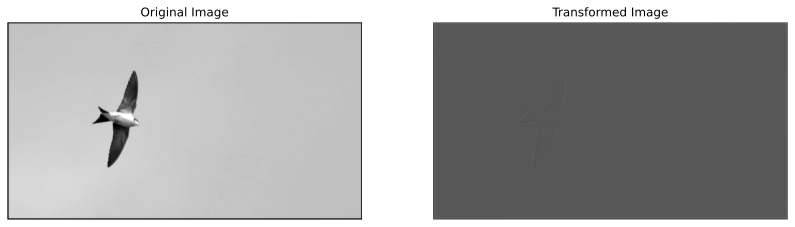

In [141]:
# Apply Δ_D and plot the results
apply_operator_and_plot(f, m, n, Δ_D, original_image)

After applying the Laplacian operator to the original image, we get the transformed image on the right. We observe that the background is much darker, and the bird's shape is highlithed by subtle edges (make sure to have your computer on full brightness). The Laplacian operator emphasizes changes in intensity, resulting in edge detection.

#### b)

To smoothly merge two images, we will now implement a function `seamless_cloning` which incorporates each $g$ into the respective color channel in $f$ as $f_{new} = g + h$ in $\Omega$.

In [143]:
def seamless_cloning(image_F: np.ndarray, image_G: np.ndarray, pos_F: list, pos_G: list, patch_size: list) -> np.ndarray:
    '''
    Performs seamless cloning of a region from image_G into image_F

    Parameters:
    - image_F: the image F
    - image_G: the image G
    - pos_F: top left pixel position of omega_inner in G
    - pos_G: top left pixel position of omega_inner in F where to input the patch from G
    - patch_size: size of patch (omega)

    Returns:
    - image_F_writeable: modified image `image_F` with the seamless patch inserted from `image_G`

    '''

    m, n = patch_size
    
    # Make a writable copy of image_F
    image_F_writable = np.copy(image_F)

    # Go through each color channel separately
    for channel in range(3):

        f = image_F[:, :, channel]
        g = image_G[:, :, channel]

        g_omega_inner = g[pos_G[1]:pos_G[1]-2+n, pos_G[0]:pos_G[0]-2+m]
        g_omega = g[pos_G[1]-1:pos_G[1]-1+n, pos_G[0]-1:pos_G[0]-1+m]
        f_omega = f[pos_F[1]-1:pos_F[1]-1+n, pos_F[0]-1:pos_F[0]-1+m]

        Δ_D = construct_laplacian_operator(m, n, 2)

        h_boundary = np.zeros((n, m))
        # h(∂Ω) = f(∂Ω) - g(∂Ω)
        h_boundary[0, :] = f_omega[0, :] - g_omega[0, :]  # top
        h_boundary[-1, :] = f_omega[-1, :] - g_omega[-1, :]  # bottom
        h_boundary[:, 0] = f_omega[:, 0] - g_omega[:, 0]  # left
        h_boundary[:, -1] = f_omega[:, -1] - g_omega[:, -1]  # right
        h_boundary_vec = h_boundary.flatten()

        # Δ_D * h = b (on ∂Ω)
        b = Δ_D@h_boundary_vec
        b_sliced = b.reshape(h_boundary.shape)[1:-1, 1:-1] * (-1)
        b_sliced_vec = b_sliced.flatten()

        Δ_D_new = construct_laplacian_operator(m-2, n-2, 2)

        h, info = cg(Δ_D_new, b_sliced_vec)
        if info != 0:
            print(f"Solver did not converge, info: {info}")

        h_omega_inner = h.reshape(g_omega_inner.shape)
        h_omega = h_boundary + np.pad(h_omega_inner, pad_width=1, mode = 'constant', constant_values=0)

        f_new = g_omega + h_omega

        # Insert the cloned patch back into the writable copy of the original image
        image_F_writable[pos_F[1]-1:pos_F[1]-1+n, pos_F[0]-1:pos_F[0]-1+m, channel] = f_new
    
    return image_F_writable

#### c)

We will now test our `seamless_cloning` algorithm by applying it to two examples: blending a bear into a water background and merging a bird and plane scene. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07232075..1.0259275].


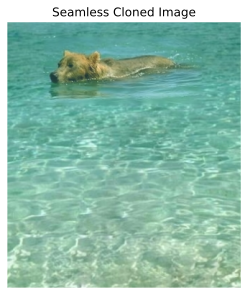

In [147]:
import matplotlib.image as img

# Image paths
water_raw = "data/water.jpg"
bear_raw = "data/bear.jpg"

# Load the images as arrays
water = img.imread(water_raw).astype(np.float32)/255
bear = img.imread(bear_raw).astype(np.float32)/255

# Test the seamless cloning function for bear in water image
water_bear = seamless_cloning(water, bear, [51, 20], [30, 35], [225, 98])

# Display the result
plt.imshow(water_bear)
plt.title("Seamless Cloned Image")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.274121].


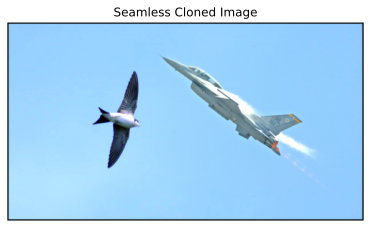

In [148]:
# Image paths
bird_raw = "data/bird.jpg"
plane_raw = "data/plane.jpg"

# Load the images as arrays
bird = img.imread(bird_raw).astype(np.float32)/255
plane = img.imread(plane_raw).astype(np.float32)/255

# Test the seamless cloning function for plane in bird image
bird_plane = seamless_cloning(bird, plane, [524, 100], [173, 99], [627, 501])

# Display the result
plt.imshow(bird_plane)
plt.title("Seamless Cloned Image")
plt.axis('off')
plt.show()

Our seamless cloning appears to work well. We observe that our algorithm works best for our last example photo, given that the background is more color-monotone.

#### d)

Now we want to generalize our algorithm to work with an arbitrary area, instead of only for the rectangle case we have used so far. For this we use an approach where we implement the same logic as previously, but we add a binary mask that will indicate the shape we want to blend for.

We begin by defining a new Laplacian operator function that will take our mask into account whilst generating.

In [47]:
def create_laplacian_operator_with_mask(n: int, m: int, mask: np.ndarray) -> np.ndarray:
    '''
    Constructs a 2D discrete Laplacian operator Δ_D wrt given binary mask
    
    Parameters:
    - m: number of rows 
    - n: number of columns
    - mask: binary mask
    
    Returns:
    - Δ_D: sparse matrix representing the 2D discrete Laplacian operator Δ_D

    '''
    
    # Initialize the Laplace matrix for a (n x m) grid
    size = n * m
    D = np.zeros((size, size))

    # Create arrays to store rows and columns to keep (not set to 0)
    keep_rows = np.zeros(size, dtype=bool)
    keep_columns = np.zeros(size, dtype=bool)
    
    for i in range(n):
        for j in range(m):
            index = i * m + j  # Flattened index for the (i, j) position
            
            # Only proceed if the mask at (i, j) is active
            if mask[i, j] == 1:
                # Count active neighbors
                neighbor_count = 0
                
                # Left neighbor
                if j > 0 and mask[i, j - 1] == 1:
                    neighbor_count += 1

                # Right neighbor
                if j < m - 1 and mask[i, j + 1] == 1:
                    neighbor_count += 1

                # Top neighbor
                if i > 0 and mask[i - 1, j] == 1:
                    neighbor_count += 1

                # Bottom neighbor
                if i < n - 1 and mask[i + 1, j] == 1:
                    neighbor_count += 1

                # Mark row and column as "keep" if exactly four neighbors
                if neighbor_count == 4:
                    keep_rows[index] = True
                    keep_columns[index] = True
                    D[index, index] = 4
                    
                    # Set off-diagonal elements for active neighbors
                    if j > 0 and mask[i, j - 1] == 1:
                        D[index, index - 1] = -1
                    if j < m - 1 and mask[i, j + 1] == 1:
                        D[index, index + 1] = -1
                    if i > 0 and mask[i - 1, j] == 1:
                        D[index, index - m] = -1
                    if i < n - 1 and mask[i + 1, j] == 1:
                        D[index, index + m] = -1

    # Apply the row and column masking
    for row in range(size):
        if not keep_rows[row]:
            D[row, :] = 0
    for col in range(size):
        if not keep_columns[col]:
            D[:, col] = 0

    return D

Now we will create our function for seamless cloning with a given mask. We use the parameter `mask` in order to define the boundary of our mask. Now we can use this in order to blend on this arbitrary boundary instead of always on a rectangle (edges of patch).

In [149]:
def seamless_cloning_with_mask(image_F: np.ndarray, image_G: np.ndarray, pos_F: list, pos_G: list, patch_size: list, mask: np.ndarray) -> np.ndarray:
    '''
    Performs seamless cloning of an arbitrary region from image_G into image_F

    Parameters:
    - image_F: the image F
    - image_G: the image G
    - pos_F: top left pixel position of omega_inner in G
    - pos_G: top left pixel position of omega_inner in F where to input the patch from G
    - patch_size: size of patch (omega)
    - mask: binary mask that indicates region to blend

    Returns:
    - image_F_writable: modified image `image_F` with the seamless patch inserted from `image_G`

    '''

    m, n = patch_size

    # Erode the mask slightly to create an inner boundary
    eroded_mask = binary_erosion(mask)

    # Subtract the eroded mask from the original to get only the boundary of the mask
    boundary_mask = mask ^ eroded_mask

    # Add top and bottom edges to the boundary mask
    for row in range(n):
        true_indices = np.where(mask[row, :])[0]
        if len(true_indices) > 0:
            if row == 0 or row == (n-1):
                boundary_mask[row, true_indices[0]:true_indices[-1] + 1] = True

    # Add left and right edges to the boundary mask
    for col in range(m):
        true_indices = np.where(mask[:, col])[0]
        if len(true_indices) > 0:
            if col == 0 or col == (m - 1):
                boundary_mask[true_indices[0]:true_indices[-1] + 1, col] = True

    # Make a writable copy of image_F
    image_F_writable = np.copy(image_F)

    # Go through each color channel separately
    for channel in range(3):

        f = image_F[:, :, channel]
        g = image_G[:, :, channel]

        g_omega = g[pos_G[1]-1:pos_G[1]-1+n, pos_G[0]-1:pos_G[0]-1+m]
        f_omega = f[pos_F[1]-1:pos_F[1]-1+n, pos_F[0]-1:pos_F[0]-1+m]

        # Apply the mask to limit cloning to this region
        g_omega = g_omega * mask
        f_omega = f_omega * mask

        # Creating a Δ_D the same way as we did in task b)
        Δ_D = construct_laplacian_operator(m, n, 2)
 
        h_boundary = np.zeros((n, m))
        h_boundary[boundary_mask] = f_omega[boundary_mask] - g_omega[boundary_mask]
        h_boundary_vec = h_boundary.flatten()

        b = Δ_D @ h_boundary_vec
        inner_mask = mask & ~boundary_mask
        b_sliced_vec = b * inner_mask.flatten() * (-1)

        # Creating a Δ_D wrt the given binary mask
        Δ_D_new = create_laplacian_operator_with_mask(n, m, mask)

        h, info = cg(Δ_D_new, b_sliced_vec)
        if info != 0:
            print(f"Solver did not converge, info: {info}")

        h_omega_inner = h.reshape(h_boundary.shape)
        h_omega = h_boundary + h_omega_inner

        f_new = g_omega + h_omega

        # Insert the cloned patch back into the writable copy of the original image, applying the mask
        image_F_writable[pos_F[1]:pos_F[1]+n, pos_F[0]:pos_F[0]+m, channel] = (
            image_F_writable[pos_F[1]:pos_F[1]+n, pos_F[0]:pos_F[0]+m, channel] * (1 - mask) + (f_new * mask)
        )
    
    return image_F_writable

In order to test our code, we have decided to create an elliptical mask for our bear in water example. 

In [150]:
def create_elliptical_mask(patch_size: list) -> np.ndarray:
    '''
    Creates an elliptical binary mask

    Parameters:
    - patch_size: size of square patch to place the mask in

    Returns:
    - mask: an elliptical binary mask (with the square patch dimension)
    
    '''

    m, n = patch_size
    mask = np.zeros((n, m), dtype=bool)
    rr, cc = ellipse((n - 1) / 2, (m - 1) / 2, n / 2, m / 2, shape=mask.shape)
    mask[rr, cc] = True

    return mask

Now we are ready to create our elliptical mask and call `seamless_cloning_with_mask` in order to seamlessly clone.

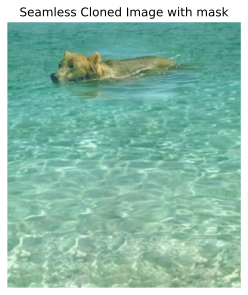

In [151]:
# Image paths
water_raw = "data/water.jpg"
bear_raw = "data/bear.jpg"

# Load the images as arrays
water = img.imread(water_raw).astype(np.float32)/255
bear = img.imread(bear_raw).astype(np.float32)/255

# Create an elliptical mask
elliptical_mask = create_elliptical_mask([225, 98])

# Test the seamless cloning function for the elliptical mask
water_bear = seamless_cloning_with_mask(water, bear, [51, 20], [30, 35], [225, 98], elliptical_mask)

# Display the result
plt.imshow(water_bear)
plt.title("Seamless Cloned Image with mask")
plt.axis('off')
plt.show()

Our new algoritm allows the cloning to appear even more seamless than earlier.

#### e)

**Where the algorithm works well**

The algorithm effectively blends the source image into the destination background if it is relatively uniform or has a gradual color variation. For example sky, water or grass works well for destination pictures as it has soft color variations. When boundary colors and illumination levels in both the source and destination images are similar, the algorithm can seamlessly integrate them. This is useful for images taken under similar lighting conditions or for photos with soft lighting that naturally blend into each other. This approach is efficient for objects with closed boundaries without holes or gaps, as it focuses on blending around the object's outline. 


**Limitations**

The algorithm will not work well when there is a substantial difference in color or lighting between the boundaries of the source and destination image. It will struggle to blend seamlessly, resulting in unnatural-looking edges after cloning. When there are complex textures or high-frequency details, the algorithm may smooth out fine areas, as it only ensures gradient continuity and does not intricate details within the masked region. When blending images with objects containing holes, the algorithm may ignore these internal spaces, treating the object as a closed object with a single boundary. This can lead to a blurred or unclear appearance in regions that should be treated differently.

#### References

- Perez, P., Gangnet, M., & Blake, A. (2003). *Poisson image editing*. Association for Computing Machinery. Retrieved from https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf
- Wikipedia contributors (2024, last edit). *Bézier curve*. Wikipedia. Retrieved from https://en.wikipedia.org/wiki/B%C3%A9zier_curve